In [43]:
import pyemma.coordinates as coor
from pyemma import config 
config.show_progress_bars = False 
from glob import glob
import os
import numpy as np
%matplotlib inline
from matplotlib.pyplot import *

from sklearn.decomposition import PCA
from sklearn import manifold 
import mdtraj
from sklearn.cluster import KMeans
from scipy.spatial import kdtree # for extracting nearest point to KMeans cluster centers
import seaborn as sns

In [42]:
def save_cluster_centers(method, X_r, k, subsample, trjs):
    tree = kdtree.KDTree(X_r)
    for i in range(k.cluster_centers_.shape[0]):
        kc = k.cluster_centers_[i]
        frame = tree.query(kc)[1] * subsample
        trjs[frame].save_pdb(method + str(i) + ".pdb")

In [3]:
indir = os.getcwd() + "/c"

# Select all relevant torsion angles

In [4]:
torsion_idx =   [["O4'", "C1'", "N9", "C8"], # A or G
                 ["O4'", "C1'", "N1", "C6"], # C or T(U)
                 ["O4'", "C4'", "C5'", "O5'"], # bb
                 ["C4'", "C5'", "O5'","P"],
                 ["C4'", "C5'", "O3'","P"],
                 ["O5'", "P", "O3'", "C3'"]]

torsion_idx =   [["O4'", "C1'", "N1", "C6"], # actually just use the common atoms for all
                 ["O4'", "C4'", "C5'", "O5'"], # bb
                 ["C4'", "C5'", "O5'","P"],
                 ["C4'", "C5'", "O3'","P"],
                 ["O5'", "P", "O3'", "C3'"]]

In [5]:
topfile = indir + '/main-changeCA-c.pdb'

In [6]:
top = mdtraj.load_topology(topfile)
trj = mdtraj.load_xtc('/media/DATA/huang_lab/gwang/c/main-fitBH-sd9_c_100ns.xtc', top)
trjs = [mdtraj.load_xtc(t, top) for t in glob(indir + "/*xtc")]
trjs = mdtraj.join(trjs)


/usr/local/lib/python2.7/site-packages/pyemma/__init__.py:108: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.
  .format(latest=latest, current=current), category=UserWarning)


In [7]:
ncols = 4 # 4 atoms to calculate a torsion angle
dihs = np.array([])

    
dih = mdtraj.compute_chi1(trjs)[1].T # first - the protein 
dih = np.vstack((dih, mdtraj.compute_phi(trjs)[1].T))
dih = np.vstack((dih, mdtraj.compute_psi(trjs)[1].T))

for res in top.residues:
    for torsion in torsion_idx:
        atom_names = [atom.name for atom in res.atoms] 
        if all(t in atom_names for t in torsion):

            res_ids = []
            res_i = []

            for t in torsion:
                res_ids.append([atom.index for atom in res.atoms if atom.name == t])
                res_i.append([atom for atom in res.atoms if atom.name == t])
            res_ids = np.array(res_ids)
            res_ids = res_ids.reshape(res_ids.size/ncols, ncols)
            dih = np.vstack((dih, mdtraj.compute_dihedrals(trjs, res_ids).T)) # nucleic acid
if not dihs.any():
    dihs = dih
else:
    dihs = np.hstack((dihs, dih))           
data = np.vstack((np.sin(dihs),np.cos(dihs))).T

In [8]:
data.shape

(44044, 590)

# LINEAR Dimensionality reduction

In [49]:
n_clusters=20 # chosen to be approx the number of visible clusters in tICA
kmeans = KMeans(n_clusters)

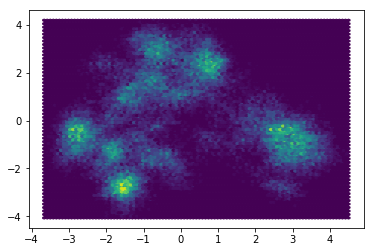

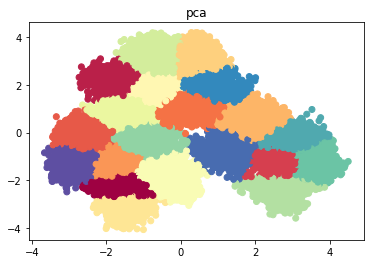

In [56]:
subsample = 1 # subsample data to make calculations faster
X = data[::subsample].astype(np.float)
rmsds_lin = []


method = "pca"

pca = PCA()
pca_dihs = pca.fit(X)
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
hexbin(X_r[:,0], X_r[:,1])
show()
k = kmeans.fit(X_r)
title("pca")
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
show()

save_cluster_centers(method, X_r, k, subsample, trjs)


# # get rmsd of each cluster
# clustered_trjs = []
# for c in range(n_clusters):
#     idx = np.multiply(subsample, np.where(k.labels_ == c))[0]
#     clustered_trjs.append(trjs[idx])
    
# cluster_mean_rmsd = []
# for traj_cluster in clustered_trjs:
#     traj_cluster = traj_cluster[::25]
#     distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
#     for i in range(traj_cluster.n_frames):
#         distances[i] = mdtraj.rmsd(traj_cluster, traj_cluster, i)
#     cluster_mean_rmsd.append(distances.mean())    
# plot(cluster_mean_rmsd)
# rmsds_lin.append(cluster_mean_rmsd)
# show()


lag that explains the most variance with the least components = 46


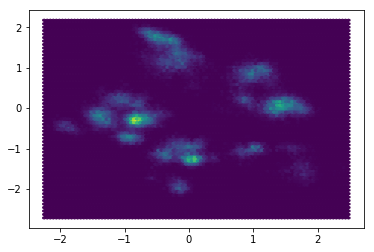

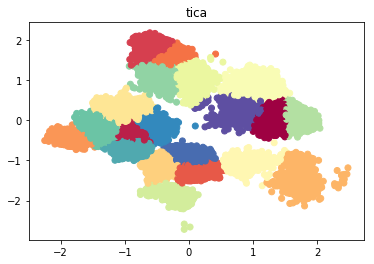

In [57]:
method = "tica"

# find optimal lag time
minlag = 10
maxlag = 150
lags = []
for lag in np.linspace(minlag, maxlag, 20):
     
    tica_dihs = coor.tica(X, lag=int(lag), var_cutoff=0.9)
    lags.append((tica_dihs.dimension(),int(lag)))

lag = min(lags)[1]
print "lag that explains the most variance with the least components = " + str(lag)

# do tica with optimal lag
tica_dihs = coor.tica(X, lag=int(lag), var_cutoff=0.9)
X_r =  tica_dihs.get_output()[0].T[:2].T
hexbin(*X_r.T)
show()
k = kmeans.fit(X_r)
title("tica")
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
show()

save_cluster_centers(method, X_r, k, subsample, trjs)


# # get rmsd of each cluster
# clustered_trjs = []
# for c in range(n_clusters):
#     idx = np.multiply(subsample, np.where(k.labels_ == c))[0]
#     clustered_trjs.append(trjs[idx])
    
# cluster_mean_rmsd = []
# for traj_cluster in clustered_trjs:
#     traj_cluster = traj_cluster[::25]
#     distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
#     for i in range(traj_cluster.n_frames):
#         distances[i] = mdtraj.rmsd(traj_cluster, traj_cluster, i)
#     cluster_mean_rmsd.append(distances.mean())    
# plot(cluster_mean_rmsd)
# rmsds_lin.append(cluster_mean_rmsd)
# show()


# NONLINEAR Dimensionality reduction


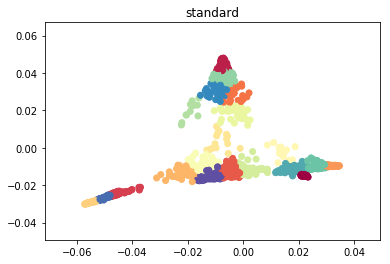

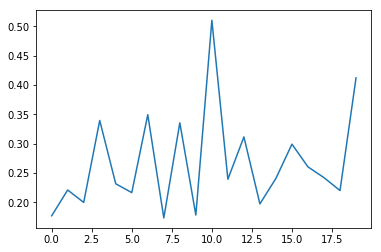

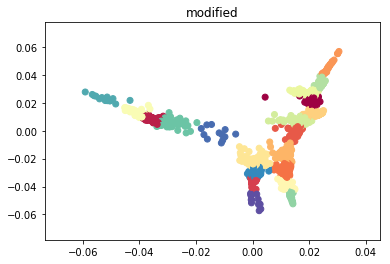

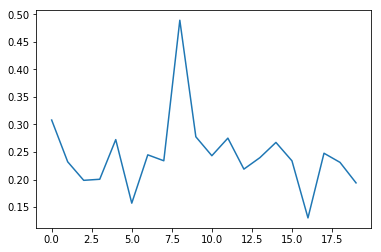

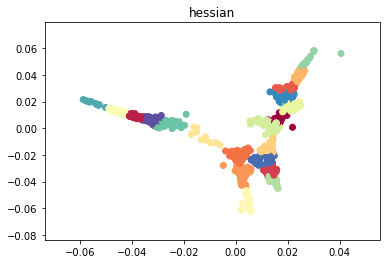

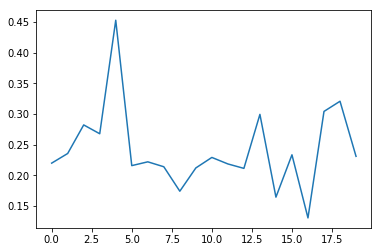

/usr/local/lib/python2.7/site-packages/pyamg/__init__.py:54: UserWarning: SciPy 0.7 or above is recommended for this version of                      PyAMG (detected version 1.0.0)
  UserWarning)


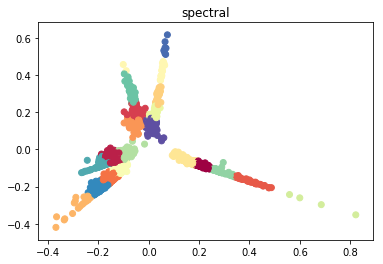

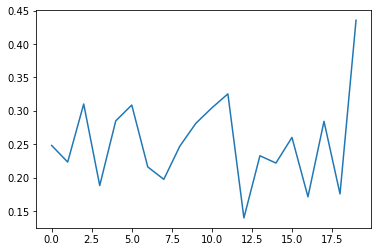

In [53]:
subsample = 25 # subsample data to make calculations faster
X = data[::subsample].astype(np.float)
neigh = 40

rmsds_nonlin = []
method = "standard"

X_r, err = manifold.locally_linear_embedding(X, n_neighbors=neigh, n_components=2, method = method)
k = kmeans.fit(X_r)
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
title(method)
show()
save_cluster_centers(method, X_r, k, subsample, trjs)
# get rmsd of each cluster
clustered_trjs = []
for c in range(n_clusters):
    idx = np.multiply(subsample, np.where(k.labels_ == c))[0]
    clustered_trjs.append(trjs[idx])
    
cluster_mean_rmsd = []
for traj_cluster in clustered_trjs:
    distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
    for i in range(traj_cluster.n_frames):
        distances[i] = mdtraj.rmsd(traj_cluster, traj_cluster, i)
    cluster_mean_rmsd.append(distances.mean())    
plot(cluster_mean_rmsd)
rmsds_nonlin.append(cluster_mean_rmsd)
show()



method = "modified"

X_r, err = manifold.locally_linear_embedding(X, n_neighbors=neigh, n_components=2, method = method)
k = kmeans.fit(X_r)
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
title(method)
show()
save_cluster_centers(method, X_r, k, subsample, trjs)

# get rmsd of each cluster
clustered_trjs = []
for c in range(n_clusters):
    idx = np.multiply(subsample, np.where(k.labels_ == c))[0]
    clustered_trjs.append(trjs[idx])
    
cluster_mean_rmsd = []
for traj_cluster in clustered_trjs:
    distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
    for i in range(traj_cluster.n_frames):
        distances[i] = mdtraj.rmsd(traj_cluster, traj_cluster, i)
    cluster_mean_rmsd.append(distances.mean())    
plot(cluster_mean_rmsd)
rmsds_nonlin.append(cluster_mean_rmsd)
show()



method = "hessian"

X_r, err = manifold.locally_linear_embedding(X, n_neighbors=neigh, n_components=2, method = method, eigen_solver="dense")

k = kmeans.fit(X_r)
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
title(method)
show()
save_cluster_centers(method, X_r, k, subsample, trjs)

# get rmsd of each cluster
clustered_trjs = []
for c in range(n_clusters):
    idx = np.multiply(subsample, np.where(k.labels_ == c))[0]
    clustered_trjs.append(trjs[idx])
    
cluster_mean_rmsd = []
for traj_cluster in clustered_trjs:
    distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
    for i in range(traj_cluster.n_frames):
        distances[i] = mdtraj.rmsd(traj_cluster, traj_cluster, i)
    cluster_mean_rmsd.append(distances.mean())    
plot(cluster_mean_rmsd)
rmsds_nonlin.append(cluster_mean_rmsd)
show()



method = "spectral"

embedder = manifold.SpectralEmbedding(n_components=2,n_neighbors=neigh, random_state=0, eigen_solver="arpack")
X_r = embedder.fit_transform(X)
k = kmeans.fit(X_r)
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
title(method)
show()
save_cluster_centers(method, X_r, k, subsample, trjs)
# get rmsd of each cluster
clustered_trjs = []
for c in range(n_clusters):
    idx = np.multiply(subsample, np.where(k.labels_ == c))[0]
    clustered_trjs.append(trjs[idx])
    
cluster_mean_rmsd = []
for traj_cluster in clustered_trjs:
    distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
    for i in range(traj_cluster.n_frames):
        distances[i] = mdtraj.rmsd(traj_cluster, traj_cluster, i)
    cluster_mean_rmsd.append(distances.mean())    
plot(cluster_mean_rmsd)
rmsds_nonlin.append(cluster_mean_rmsd)
show()




In [66]:
len(r[0])

20

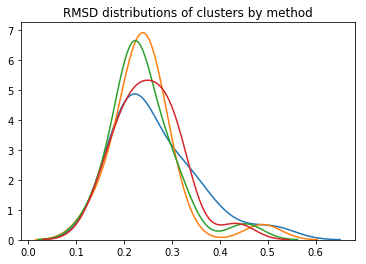

In [69]:
legs = "pca","tica","hessian", "spectral", "modified", "standard"
rmsds = rmsds_lin + rmsds_nonlin
title("RMSD distributions of clusters by method")
_ = [sns.distplot(r[0], hist=False, rug=False) for r in zip(rmsds, legs)]



/usr/local/lib/python2.7/site-packages/pyamg/__init__.py:54: UserWarning: SciPy 0.7 or above is recommended for this version of                      PyAMG (detected version 1.0.0)
  UserWarning)


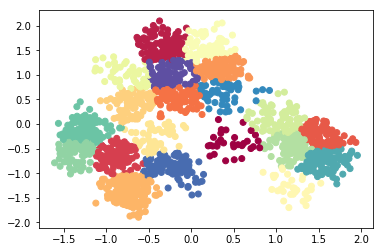

In [237]:
embedder = manifold.SpectralEmbedding(n_components=2,random_state=0, eigen_solver="arpack", affinity="rbf")
X_r = embedder.fit_transform(X) 
k = kmeans.fit(X_r)
scatter(X_r[:, 0], X_r[:, 1], c = k.labels_, cmap=cm.Spectral)
show()

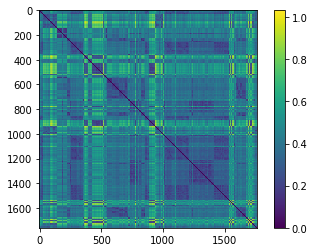

In [296]:
clustered_trj = mdtraj.join(clustered_trjs) # sort the frames by cluster

distances = np.empty((clustered_trj.n_frames, clustered_trj.n_frames))
for i in range(clustered_trj.n_frames):
    distances[i] = mdtraj.rmsd(clustered_trj, clustered_trj, i)
imshow(distances)
colorbar()

In [298]:
print distances.mean()

0.427274681149


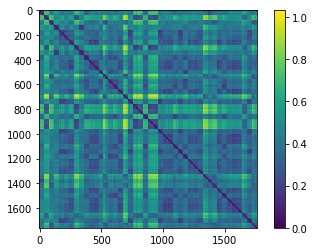

In [275]:
asd = trjs[::subsample]
distances = np.empty((asd.n_frames, asd.n_frames))
for i in range(asd.n_frames):
    distances[i] = mdtraj.rmsd(asd, asd, i)
imshow(distances)
colorbar()

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


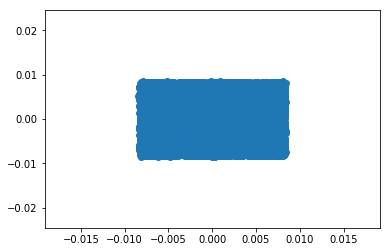

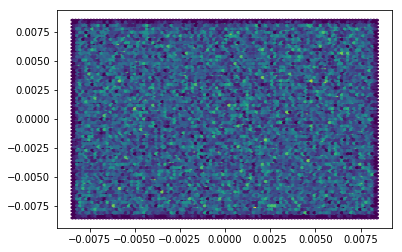

In [357]:
from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding

n_components = 2
radius = 1
geom = Geometry(#adjacency_method = 'cyflann' , 
                adjacency_kwds = { 'radius': radius } , 
                affinity_method = 'gaussian' , 
                affinity_kwds = { 'radius': radius } , 
                laplacian_method = 'geometric' , 
                laplacian_kwds = { 'scaling_epps': radius })

X_r = SpectralEmbedding ( n_components = n_components, eigen_solver = 'arpack', geom = geom )
X_r = X_r.fit_transform(X)
scatter(X_r[:, 0], X_r[:, 1], cmap=cm.Spectral)
show()
hexbin(*X_r.T)